In [1]:
import sys
import shutil
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import flopy
%matplotlib inline

flopy is installed in /Users/mnfienen/Documents/GIT/flopy/flopy


In [2]:
def make_grid(nlay, nrow, ncol, lx, slopels, slopebot, top0):
    top = np.zeros((nrow, ncol), dtype=np.float)
    botm = np.zeros((nlay, nrow, ncol), dtype=np.float)
    delr = lx / ncol
    delc = 1.
    x = 0.5 * delr
    for j in range(ncol):
        tp = top0 + x * slopels
        bt = 0 + x * slopebot
        top[:, j] = tp
        thick = tp - bt
        delz = thick / nlay
        for k in range(nlay):
            botm[k, :, j] = tp - (k + 1) * delz
        x += delr
        
    delr = np.ones((ncol)) * delr
    delc = np.ones((nrow)) * delc
    mg = flopy.discretization.StructuredGrid(nlay=nlay, nrow=nrow, ncol=ncol,
                                             delr=delr, delc=delc, top=top, botm=botm)
    return (delr, delc, top, botm)

In [3]:
def calcdens(c, rho0=1000., drhodc=0.7):
    return rho0 + drhodc * c

# these two functions are used to calcualate where along the beach front the sea level intersects
def get_sealevel(t, sl_start, slr_rate):
    return sl_start + slr_rate * t

def get_top(x, top0, slopels):
    return top0 + x * slopels

In [4]:
def get_model(ws, name, nlay, nrow, ncol, lx, slopels, slopebot, 
              top0, sl_start, slr_rate, time_end,
              hydraulic_conductivity, specific_storage, porosity, 
              recharge, inflow_rate,
              alpha_l, alpha_t,
              cfresh, csalt,
              nper=100,
              hstrt=None, cstrt=None,
              converge_continue=False,
              constant_concentration=False,
              verbosity_level=1):

    delr, delc, top, botm = make_grid(nlay, nrow, ncol, lx, 
                                      slopels, slopebot, top0)

    nstp = 1
    perlen = nper * [time_end / nper]
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp, 1.0))

    nouter, ninner = 100, 300
    hclose, rclose, relax = 1e-7, 1e-5, 0.97

    # build MODFLOW 6 files
    sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6',
                                 exe_name=os.path.abspath('../bin/macos/mf6beta'),
                                 verbosity_level=verbosity_level,
                                 sim_ws=ws)
    if converge_continue:
        sim.name_file.continue_ = True
    # create tdis package
    tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS',
                                 nper=nper, perioddata=tdis_rc)

    # create gwf model
    gwfname = 'gwf_' + name
    gwtname = 'gwt_' + name
    
    # set up groundwater flow model
    gwf = flopy.mf6.ModflowGwf(sim, modelname=gwfname, newtonoptions=True)
    
    # set up IMS solver
    imsgwf = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                  outer_hclose=hclose,
                                  outer_maximum=nouter,
                                  under_relaxation='DBD',
                                  inner_maximum=ninner,
                                  inner_hclose=hclose, rcloserecord=rclose,
                                  linear_acceleration='BICGSTAB',
                                  scaling_method='NONE',
                                  reordering_method='NONE',
                                  relaxation_factor=relax,
                                  no_ptcrecord=True,
                                  filename='{}.ims'.format(gwfname))
    sim.register_ims_package(imsgwf, [gwfname])

    # set up dis package
    dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm)

    # initial conditions
    if hstrt is None:
        hstrt = sl_start
    ic = flopy.mf6.ModflowGwfic(gwf, strt=hstrt)

    # node property flow
    npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=False,
                                  save_flows=True,
                                  save_specific_discharge=True,
                                  icelltype=1,
                                  k=hydraulic_conductivity)
    
    # storage
    sto = flopy.mf6.ModflowGwfsto(gwf, iconvert=1, sy=porosity, ss=specific_storage)

    hhoptions = [('HHFORMULATION'), ]
    hhoptions.append(('LHS'))

    # add buoyancy
    buy = flopy.mf6.ModflowGwfbuy(gwf, hhoptions=hhoptions)

    # Set up GHB
    delv = sl_start / nlay
    cond = delc[0] * delv * hydraulic_conductivity / (0.5 * delr[0])
    sl_end = get_sealevel(time_end, sl_start, slr_rate)
    
    # linearly interpolate the sea level from start to end
    timeseries = [(0.0, sl_start), (time_end, sl_end)]
    
    # ghb1 is the left side of the model and represented using a time series
    ghblist1 = []
    for k in range(nlay):
        ghblist1.append([(k, 0, 0), 'sealevel', cond, csalt, calcdens(csalt)])
    ghb1 = flopy.mf6.ModflowGwfghb(gwf,
                                   stress_period_data=ghblist1,
                                   print_input=True,
                                   print_flows=True,
                                   save_flows=False,
                                   pname='GHB-1',
                                   auxiliary=['CONCENTRATION', 'DENSITY'],
                                   timeseries=timeseries,
                                   filename='{}.ghb'.format(gwfname))
    
    # apply the time series of sea level rise to the left side (e.g. ghb1)
    ghb1.ts.time_series_namerecord = 'sealevel'
    ghb1.ts.interpolation_methodrecord = 'linearend'

    # set another ghb to represent sea level on the top of the model. 
    # also set up how much of the slope area gets recharge

    delt = time_end / nper
    ghbdict = {} # ghb
    rchdict = {} # recharge (R decreases comensurate with GHB expanding)
    cncdict = {} # constant concentration
    cond = delc[0] * delr[0] * hydraulic_conductivity / (0.5 * delv)
    for iper, t in enumerate(np.arange(delt, time_end + delt, delt)):
        sl = get_sealevel(t, sl_start, slr_rate)
        ghblist = []
        rchlist = []
        cnclist = []
        x = delr[0] / 2.
        for j in range(ncol):
            x0 = x - delr[0] / 2.
            x1 = x + delr[0] / 2
            tp0 = get_top(x0, top0, slopels)
            tp1 = get_top(x1, top0, slopels)
            if sl < tp0 and sl < tp1:
                # sea level is lower than the top of the model cell
                fcond = 0.
            elif sl > tp0 and sl > tp1:
                # sea level higher than both edges of the model cell
                fcond = 1.
            else:
                # sea level intersects sloping top of cell so calculate
                # fraction to use for conductance multiplier
                # e.g. fraction of the cell that is flooded from the sea
                fcond = (sl - tp0) / (tp1 - tp0)
            if fcond > 0.:
                ghblist.append([(0, 0, j), sl, fcond * cond, csalt, calcdens(csalt), sl])
            # scale recharge by the fraction of the cell that is inundated
            frch = 1. - fcond
            if frch > 0.:
                rchlist.append([(0, 0, j), recharge * frch])
            if fcond == 1.:
                cnclist.append([(0, 0, j), csalt])
            x += delr[0]
        if len(ghblist) > 0:
            ghbdict[iper] = ghblist
        if len(rchlist) > 0:
            rchdict[iper] = rchlist
        if len(cnclist) > 0:
            cncdict[iper] = cnclist
    if len(ghbdict) > 0:
        ghb2 = flopy.mf6.ModflowGwfghb(gwf,
                                       stress_period_data=ghbdict,
                                       print_input=True,
                                       print_flows=True,
                                       save_flows=False,
                                       auxiliary=['CONCENTRATION', 'DENSITY', 'ELEVATION'],
                                       pname='GHB-2',
                                       filename='{}2.ghb'.format(gwfname))
    if len(rchdict) > 0:
        rch = flopy.mf6.ModflowGwfrch(gwf,
                                      stress_period_data=rchdict,
                                      print_input=True,
                                      print_flows=True,
                                      save_flows=False)
        
    # set up wells for freshwater inflow from the RHS (freshwater so conc=0 see aux var below)
    wellist1 = []
    qpercell = inflow_rate / nlay
    for k in range(nlay):
        wellist1.append([(k, 0, ncol - 1), qpercell, 0.])
    wel1 = flopy.mf6.ModflowGwfwel(gwf,
                                   stress_period_data=wellist1,
                                   print_input=True,
                                   print_flows=True,
                                   save_flows=False,
                                   pname='WEL-1',
                                   auxiliary='CONCENTRATION',
                                   filename='{}.wel'.format(gwfname))

    # output control
    saverecord = {0: [('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                  1: [('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                  nper - 1: [('HEAD', 'ALL'), ('BUDGET', 'ALL')]}
    printrecord = {0: [('HEAD', 'ALL'), ('BUDGET', 'LAST')],
                  1: None,
                  nper - 1: [('HEAD', 'ALL'), ('BUDGET', 'LAST')]}
    oc = flopy.mf6.ModflowGwfoc(gwf,
                                budget_filerecord='{}.cbc'.format(gwfname),
                                head_filerecord='{}.hds'.format(gwfname),
                                headprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=saverecord,
                                printrecord=printrecord)

    # create gwt model
    gwt = flopy.mf6.MFModel(sim, model_type='gwt6', modelname=gwtname,
                            model_nam_file='{}.nam'.format(gwtname))

    # set up a separate solver instance for transport model
    imsgwt = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                  outer_hclose=hclose,
                                  outer_maximum=nouter,
                                  under_relaxation='NONE',
                                  inner_maximum=ninner,
                                  inner_hclose=hclose, rcloserecord=rclose,
                                  linear_acceleration='BICGSTAB',
                                  scaling_method='NONE',
                                  reordering_method='NONE',
                                  relaxation_factor=relax,
                                  filename='{}.ims'.format(gwtname))
    sim.register_ims_package(imsgwt, [gwt.name])

    # set up the dis package coindicent with flow model
    dis = flopy.mf6.ModflowGwtdis(gwt, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm)

    # initial conditions
    if cstrt is None:
        cstrt = 35.
    ic = flopy.mf6.ModflowGwtic(gwt, strt=cstrt)

    # advection
    adv = flopy.mf6.ModflowGwtadv(gwt, scheme='UPSTREAM')

    # dispersion
    dsp = flopy.mf6.ModflowGwtdsp(gwt, xt3d=False, diffc=0.,
                                  alh=alpha_l, ath1=alpha_t)

    # mobile storage and transfer
    porosity = porosity
    mst = flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)

    # sources
    sourcerecarray = [('GHB-1', 'AUX', 'CONCENTRATION'),
                      ('WEL-1', 'AUX', 'CONCENTRATION')]
    ssm = flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray,
                                  filename='{}.ssm'.format(gwtname))
    
    # constant concentration
    if constant_concentration:
        cnclist = []
        for k in range(1, nlay):
            cnclist.append([(k, 0, 0), 35.])
        cnc1 = flopy.mf6.ModflowGwtcnc(gwt, stress_period_data=cnclist)
        
        if len(cncdict) > 0:
            cnc2 = flopy.mf6.ModflowGwtcnc(gwt, stress_period_data=cncdict,
                                           pname='CNC-2',
                                           filename='{}2.cnc'.format(gwtname))

    # output control
    saverecord = {0: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')],
                  1: [('CONCENTRATION', 'ALL')],
                  nper - 1: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')]}
    printrecord = {0: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')],
                  1: None,
                  nper - 1: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')]}
    oc = flopy.mf6.ModflowGwtoc(gwt,
                                budget_filerecord='{}.cbc'.format(gwtname),
                                concentration_filerecord='{}.ucn'.format(
                                    gwtname),
                                concentrationprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=saverecord,
                                printrecord=printrecord)

    # GWF GWT exchange
    gwfgwt = flopy.mf6.ModflowGwfgwt(sim, exgtype='GWF6-GWT6',
                                     exgmnamea=gwfname, exgmnameb=gwtname,
                                     filename='{}.gwfgwt'.format(name))

    return sim

In [5]:
def get_results(ws, sim):
    modelnames = list(sim.model_names)
    gwfname = modelnames[0]
    gwtname = modelnames[1]
    gwf = sim.get_model(gwfname)
    gwt = sim.get_model(gwtname)

    fname = os.path.join(ws, gwfname + '.hds')
    hdobj = flopy.utils.HeadFile(fname, precision='double')
    head = hdobj.get_alldata()

    fname = os.path.join(ws, gwtname + '.ucn')
    cnobj = flopy.utils.HeadFile(fname, precision='double', text='CONCENTRATION')
    conc = cnobj.get_alldata()
    times = cnobj.get_times()
    
    fname = os.path.join(ws, gwfname + '.cbc')
    budobj = flopy.utils.CellBudgetFile(fname, precision='double')
    spdis = budobj.get_data(text='DATA-SPDIS')
    
    return head, conc, spdis, times

In [6]:
def get_colored_patch_collection(modelgrid, head=None, ec='k', fc='k', zorder=None):
    # create patches for each cell
    xv, yv, zv = modelgrid.xyzvertices
    patches = []
    for k in range(modelgrid.nlay):
        for j in range(modelgrid.ncol):
            x0 = xv[0, j]
            x1 = xv[0, j + 1]
            y0 = zv[k, 0, j]
            y1 = zv[k + 1, 0, j]
            if head is not None:
                y0 = min(y0, head[k, 0, j])
                y0 = max(y0, modelgrid.botm[k, 0, j])
            poly = [[x0, y0], [x1, y0], [x1, y1], [x0, y1], [x0, y0]]
            #print(poly)
            patch = matplotlib.patches.Polygon(poly, closed=True, edgecolor=ec, facecolor=fc)
            patches.append(patch)
    pc = matplotlib.collections.PatchCollection(patches, zorder=zorder, match_original=True, cmap='jet')
    return pc

In [7]:
def make_figure(gwf, head, conc, spdis, sl, t, top0, slopels, csalt=35., 
                vectors=True, figname=None):

    plt.rcParams['savefig.facecolor'] = '1.0'
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    ax.set_aspect('auto')
    
    pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
    pxs.plot_grid(alpha=1., lw=0.1)

    # draw a patch collection, with the water table as the top of the cell
    pc = get_colored_patch_collection(gwf.modelgrid, head, ec='none', fc='none', zorder=2)
    pc.set_array(conc.flatten())
    ax.add_collection(pc)

    cbar = plt.colorbar(pc, shrink=0.5)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('CONCENTRATION, IN GRAMS PER LITER', rotation=90)
    

    atoplot = np.ma.masked_where(head < gwf.dis.botm.array, conc)
    pxs.contour_array(atoplot, levels=np.array([.5])* csalt, 
                      linestyles = ['-'], colors=['k'])

    if vectors:
        pxs.plot_specific_discharge(spdis, head=head, color='white',
                                    kstep=1, hstep=1, pivot='mid', minlength=0.5,
                                    scale=1., width=0.001, headwidth=3., headlength=5.0, 
                                    headaxislength=4.5, minshaft=0.01,
                                    zorder=10, alpha=0.50)

    xsl = (sl - top0) / slopels
    sea_poly = [[0, sl], [xsl, sl], [0, top0], [0, sl]]
    sea_patch = matplotlib.patches.Polygon(sea_poly, closed=True, edgecolor='k', facecolor='red')
    ax.add_patch(sea_patch)        

    # head surface
    #ax.plot(gwf.modelgrid.xcellcenters[0], head[kper, 0, 0, :])
    #plt.colorbar(qm, shrink=0.5)
    ax.set_title('TIME = {:.2f} years'.format(t / 365.))
    ax.set_xlabel('DISTANCE, IN METERS')
    ax.set_ylabel('ELEVATION, IN METERS')

    plt.tight_layout()
    
    if figname is not None:
        plt.savefig(figname, dpi=300)
        plt.close(fig)
        
    return

In [8]:
def make_movie(figfile, anmfile):
    from subprocess import check_output
    vcodec = 'libx264'
    if os.path.isfile(anmfile):
        os.remove(anmfile)
    output = check_output(['ffmpeg',
                           '-f', 'image2',
                           '-i', figfile,
                           '-vb', '20M',
                           '-vcodec', vcodec,
                           '-pix_fmt', 'yuv420p',
                           anmfile])    

In [9]:
# Protection
sim = None
sim0 = None
gwf = None
ws = None
ws0 = None
head = None
head0 = None
conc = None
conc0 = None

# Run the functions above without SLR to get starting heads and concs

In [10]:
nlay = 30
nrow = 1
ncol = 100
nper = 3000
lx = 1000.
top0 = 30.
sl_start = 30.
slr_rate = 0.
time_end = 100. * 365. # convert years to days
slopels = 0.005
slopebot = 0.01
cfresh = 0.
csalt = 35.
recharge = 18.25 / 1000. / 365. # convert mm/yr to m/yr to m/day
inflow_rate = 0.15 # m^2/day
porosity = 0.20
hydraulic_conductivity = 10 # m/day
specific_storage = 0.008 # per meter
alpha_l = 1. # meter
alpha_t = 0.1 # meter

In [11]:
ws0 = 'temp/pxx_gwt_slr0'
name = 'slr'
sim0 = get_model(ws0, name, nlay, nrow, ncol, lx, slopels, slopebot, 
                 top0, sl_start, slr_rate, 3 * time_end, 
                 hydraulic_conductivity, specific_storage, porosity, 
                 recharge, inflow_rate,
                 alpha_l, alpha_t,
                 cfresh, csalt,
                 constant_concentration=True,
                 verbosity_level=1, nper=nper)
sim0.write_simulation()
v = sim0.run_simulation(report=True)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing ims package ims_0...
  writing package slr.gwfgwt...
  writing model gwf_slr...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package ghb-1...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 30 based on size of stress_period_data
    writing package ts_0...
    writing package rch_0...
INFORMATION: maxbound in ('gwf6', 'rch', 'dimensions') changed to 100 based on size of stress_period_data
    writing package wel-1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 30 based on size of stress_period_data
    writing package oc...
  writing model gwt_slr...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package dsp...
    writing package mst..

 Solving:  Stress period:   121    Time step:     1
 Solving:  Stress period:   122    Time step:     1
 Solving:  Stress period:   123    Time step:     1
 Solving:  Stress period:   124    Time step:     1
 Solving:  Stress period:   125    Time step:     1
 Solving:  Stress period:   126    Time step:     1
 Solving:  Stress period:   127    Time step:     1
 Solving:  Stress period:   128    Time step:     1
 Solving:  Stress period:   129    Time step:     1
 Solving:  Stress period:   130    Time step:     1
 Solving:  Stress period:   131    Time step:     1
 Solving:  Stress period:   132    Time step:     1
 Solving:  Stress period:   133    Time step:     1
 Solving:  Stress period:   134    Time step:     1
 Solving:  Stress period:   135    Time step:     1
 Solving:  Stress period:   136    Time step:     1
 Solving:  Stress period:   137    Time step:     1
 Solving:  Stress period:   138    Time step:     1
 Solving:  Stress period:   139    Time step:     1
 Solving:  S

 Solving:  Stress period:   288    Time step:     1
 Solving:  Stress period:   289    Time step:     1
 Solving:  Stress period:   290    Time step:     1
 Solving:  Stress period:   291    Time step:     1
 Solving:  Stress period:   292    Time step:     1
 Solving:  Stress period:   293    Time step:     1
 Solving:  Stress period:   294    Time step:     1
 Solving:  Stress period:   295    Time step:     1
 Solving:  Stress period:   296    Time step:     1
 Solving:  Stress period:   297    Time step:     1
 Solving:  Stress period:   298    Time step:     1
 Solving:  Stress period:   299    Time step:     1
 Solving:  Stress period:   300    Time step:     1
 Solving:  Stress period:   301    Time step:     1
 Solving:  Stress period:   302    Time step:     1
 Solving:  Stress period:   303    Time step:     1
 Solving:  Stress period:   304    Time step:     1
 Solving:  Stress period:   305    Time step:     1
 Solving:  Stress period:   306    Time step:     1
 Solving:  S

 Solving:  Stress period:   464    Time step:     1
 Solving:  Stress period:   465    Time step:     1
 Solving:  Stress period:   466    Time step:     1
 Solving:  Stress period:   467    Time step:     1
 Solving:  Stress period:   468    Time step:     1
 Solving:  Stress period:   469    Time step:     1
 Solving:  Stress period:   470    Time step:     1
 Solving:  Stress period:   471    Time step:     1
 Solving:  Stress period:   472    Time step:     1
 Solving:  Stress period:   473    Time step:     1
 Solving:  Stress period:   474    Time step:     1
 Solving:  Stress period:   475    Time step:     1
 Solving:  Stress period:   476    Time step:     1
 Solving:  Stress period:   477    Time step:     1
 Solving:  Stress period:   478    Time step:     1
 Solving:  Stress period:   479    Time step:     1
 Solving:  Stress period:   480    Time step:     1
 Solving:  Stress period:   481    Time step:     1
 Solving:  Stress period:   482    Time step:     1
 Solving:  S

 Solving:  Stress period:   636    Time step:     1
 Solving:  Stress period:   637    Time step:     1
 Solving:  Stress period:   638    Time step:     1
 Solving:  Stress period:   639    Time step:     1
 Solving:  Stress period:   640    Time step:     1
 Solving:  Stress period:   641    Time step:     1
 Solving:  Stress period:   642    Time step:     1
 Solving:  Stress period:   643    Time step:     1
 Solving:  Stress period:   644    Time step:     1
 Solving:  Stress period:   645    Time step:     1
 Solving:  Stress period:   646    Time step:     1
 Solving:  Stress period:   647    Time step:     1
 Solving:  Stress period:   648    Time step:     1
 Solving:  Stress period:   649    Time step:     1
 Solving:  Stress period:   650    Time step:     1
 Solving:  Stress period:   651    Time step:     1
 Solving:  Stress period:   652    Time step:     1
 Solving:  Stress period:   653    Time step:     1
 Solving:  Stress period:   654    Time step:     1
 Solving:  S

 Solving:  Stress period:   815    Time step:     1
 Solving:  Stress period:   816    Time step:     1
 Solving:  Stress period:   817    Time step:     1
 Solving:  Stress period:   818    Time step:     1
 Solving:  Stress period:   819    Time step:     1
 Solving:  Stress period:   820    Time step:     1
 Solving:  Stress period:   821    Time step:     1
 Solving:  Stress period:   822    Time step:     1
 Solving:  Stress period:   823    Time step:     1
 Solving:  Stress period:   824    Time step:     1
 Solving:  Stress period:   825    Time step:     1
 Solving:  Stress period:   826    Time step:     1
 Solving:  Stress period:   827    Time step:     1
 Solving:  Stress period:   828    Time step:     1
 Solving:  Stress period:   829    Time step:     1
 Solving:  Stress period:   830    Time step:     1
 Solving:  Stress period:   831    Time step:     1
 Solving:  Stress period:   832    Time step:     1
 Solving:  Stress period:   833    Time step:     1
 Solving:  S

 Solving:  Stress period:   994    Time step:     1
 Solving:  Stress period:   995    Time step:     1
 Solving:  Stress period:   996    Time step:     1
 Solving:  Stress period:   997    Time step:     1
 Solving:  Stress period:   998    Time step:     1
 Solving:  Stress period:   999    Time step:     1
 Solving:  Stress period:  1000    Time step:     1
 Solving:  Stress period:  1001    Time step:     1
 Solving:  Stress period:  1002    Time step:     1
 Solving:  Stress period:  1003    Time step:     1
 Solving:  Stress period:  1004    Time step:     1
 Solving:  Stress period:  1005    Time step:     1
 Solving:  Stress period:  1006    Time step:     1
 Solving:  Stress period:  1007    Time step:     1
 Solving:  Stress period:  1008    Time step:     1
 Solving:  Stress period:  1009    Time step:     1
 Solving:  Stress period:  1010    Time step:     1
 Solving:  Stress period:  1011    Time step:     1
 Solving:  Stress period:  1012    Time step:     1
 Solving:  S

 Solving:  Stress period:  1177    Time step:     1
 Solving:  Stress period:  1178    Time step:     1
 Solving:  Stress period:  1179    Time step:     1
 Solving:  Stress period:  1180    Time step:     1
 Solving:  Stress period:  1181    Time step:     1
 Solving:  Stress period:  1182    Time step:     1
 Solving:  Stress period:  1183    Time step:     1
 Solving:  Stress period:  1184    Time step:     1
 Solving:  Stress period:  1185    Time step:     1
 Solving:  Stress period:  1186    Time step:     1
 Solving:  Stress period:  1187    Time step:     1
 Solving:  Stress period:  1188    Time step:     1
 Solving:  Stress period:  1189    Time step:     1
 Solving:  Stress period:  1190    Time step:     1
 Solving:  Stress period:  1191    Time step:     1
 Solving:  Stress period:  1192    Time step:     1
 Solving:  Stress period:  1193    Time step:     1
 Solving:  Stress period:  1194    Time step:     1
 Solving:  Stress period:  1195    Time step:     1
 Solving:  S

 Solving:  Stress period:  1353    Time step:     1
 Solving:  Stress period:  1354    Time step:     1
 Solving:  Stress period:  1355    Time step:     1
 Solving:  Stress period:  1356    Time step:     1
 Solving:  Stress period:  1357    Time step:     1
 Solving:  Stress period:  1358    Time step:     1
 Solving:  Stress period:  1359    Time step:     1
 Solving:  Stress period:  1360    Time step:     1
 Solving:  Stress period:  1361    Time step:     1
 Solving:  Stress period:  1362    Time step:     1
 Solving:  Stress period:  1363    Time step:     1
 Solving:  Stress period:  1364    Time step:     1
 Solving:  Stress period:  1365    Time step:     1
 Solving:  Stress period:  1366    Time step:     1
 Solving:  Stress period:  1367    Time step:     1
 Solving:  Stress period:  1368    Time step:     1
 Solving:  Stress period:  1369    Time step:     1
 Solving:  Stress period:  1370    Time step:     1
 Solving:  Stress period:  1371    Time step:     1
 Solving:  S

 Solving:  Stress period:  1514    Time step:     1
 Solving:  Stress period:  1515    Time step:     1
 Solving:  Stress period:  1516    Time step:     1
 Solving:  Stress period:  1517    Time step:     1
 Solving:  Stress period:  1518    Time step:     1
 Solving:  Stress period:  1519    Time step:     1
 Solving:  Stress period:  1520    Time step:     1
 Solving:  Stress period:  1521    Time step:     1
 Solving:  Stress period:  1522    Time step:     1
 Solving:  Stress period:  1523    Time step:     1
 Solving:  Stress period:  1524    Time step:     1
 Solving:  Stress period:  1525    Time step:     1
 Solving:  Stress period:  1526    Time step:     1
 Solving:  Stress period:  1527    Time step:     1
 Solving:  Stress period:  1528    Time step:     1
 Solving:  Stress period:  1529    Time step:     1
 Solving:  Stress period:  1530    Time step:     1
 Solving:  Stress period:  1531    Time step:     1
 Solving:  Stress period:  1532    Time step:     1
 Solving:  S

 Solving:  Stress period:  1679    Time step:     1
 Solving:  Stress period:  1680    Time step:     1
 Solving:  Stress period:  1681    Time step:     1
 Solving:  Stress period:  1682    Time step:     1
 Solving:  Stress period:  1683    Time step:     1
 Solving:  Stress period:  1684    Time step:     1
 Solving:  Stress period:  1685    Time step:     1
 Solving:  Stress period:  1686    Time step:     1
 Solving:  Stress period:  1687    Time step:     1
 Solving:  Stress period:  1688    Time step:     1
 Solving:  Stress period:  1689    Time step:     1
 Solving:  Stress period:  1690    Time step:     1
 Solving:  Stress period:  1691    Time step:     1
 Solving:  Stress period:  1692    Time step:     1
 Solving:  Stress period:  1693    Time step:     1
 Solving:  Stress period:  1694    Time step:     1
 Solving:  Stress period:  1695    Time step:     1
 Solving:  Stress period:  1696    Time step:     1
 Solving:  Stress period:  1697    Time step:     1
 Solving:  S

 Solving:  Stress period:  1839    Time step:     1
 Solving:  Stress period:  1840    Time step:     1
 Solving:  Stress period:  1841    Time step:     1
 Solving:  Stress period:  1842    Time step:     1
 Solving:  Stress period:  1843    Time step:     1
 Solving:  Stress period:  1844    Time step:     1
 Solving:  Stress period:  1845    Time step:     1
 Solving:  Stress period:  1846    Time step:     1
 Solving:  Stress period:  1847    Time step:     1
 Solving:  Stress period:  1848    Time step:     1
 Solving:  Stress period:  1849    Time step:     1
 Solving:  Stress period:  1850    Time step:     1
 Solving:  Stress period:  1851    Time step:     1
 Solving:  Stress period:  1852    Time step:     1
 Solving:  Stress period:  1853    Time step:     1
 Solving:  Stress period:  1854    Time step:     1
 Solving:  Stress period:  1855    Time step:     1
 Solving:  Stress period:  1856    Time step:     1
 Solving:  Stress period:  1857    Time step:     1
 Solving:  S

 Solving:  Stress period:  2002    Time step:     1
 Solving:  Stress period:  2003    Time step:     1
 Solving:  Stress period:  2004    Time step:     1
 Solving:  Stress period:  2005    Time step:     1
 Solving:  Stress period:  2006    Time step:     1
 Solving:  Stress period:  2007    Time step:     1
 Solving:  Stress period:  2008    Time step:     1
 Solving:  Stress period:  2009    Time step:     1
 Solving:  Stress period:  2010    Time step:     1
 Solving:  Stress period:  2011    Time step:     1
 Solving:  Stress period:  2012    Time step:     1
 Solving:  Stress period:  2013    Time step:     1
 Solving:  Stress period:  2014    Time step:     1
 Solving:  Stress period:  2015    Time step:     1
 Solving:  Stress period:  2016    Time step:     1
 Solving:  Stress period:  2017    Time step:     1
 Solving:  Stress period:  2018    Time step:     1
 Solving:  Stress period:  2019    Time step:     1
 Solving:  Stress period:  2020    Time step:     1
 Solving:  S

 Solving:  Stress period:  2168    Time step:     1
 Solving:  Stress period:  2169    Time step:     1
 Solving:  Stress period:  2170    Time step:     1
 Solving:  Stress period:  2171    Time step:     1
 Solving:  Stress period:  2172    Time step:     1
 Solving:  Stress period:  2173    Time step:     1
 Solving:  Stress period:  2174    Time step:     1
 Solving:  Stress period:  2175    Time step:     1
 Solving:  Stress period:  2176    Time step:     1
 Solving:  Stress period:  2177    Time step:     1
 Solving:  Stress period:  2178    Time step:     1
 Solving:  Stress period:  2179    Time step:     1
 Solving:  Stress period:  2180    Time step:     1
 Solving:  Stress period:  2181    Time step:     1
 Solving:  Stress period:  2182    Time step:     1
 Solving:  Stress period:  2183    Time step:     1
 Solving:  Stress period:  2184    Time step:     1
 Solving:  Stress period:  2185    Time step:     1
 Solving:  Stress period:  2186    Time step:     1
 Solving:  S

 Solving:  Stress period:  2332    Time step:     1
 Solving:  Stress period:  2333    Time step:     1
 Solving:  Stress period:  2334    Time step:     1
 Solving:  Stress period:  2335    Time step:     1
 Solving:  Stress period:  2336    Time step:     1
 Solving:  Stress period:  2337    Time step:     1
 Solving:  Stress period:  2338    Time step:     1
 Solving:  Stress period:  2339    Time step:     1
 Solving:  Stress period:  2340    Time step:     1
 Solving:  Stress period:  2341    Time step:     1
 Solving:  Stress period:  2342    Time step:     1
 Solving:  Stress period:  2343    Time step:     1
 Solving:  Stress period:  2344    Time step:     1
 Solving:  Stress period:  2345    Time step:     1
 Solving:  Stress period:  2346    Time step:     1
 Solving:  Stress period:  2347    Time step:     1
 Solving:  Stress period:  2348    Time step:     1
 Solving:  Stress period:  2349    Time step:     1
 Solving:  Stress period:  2350    Time step:     1
 Solving:  S

 Solving:  Stress period:  2492    Time step:     1
 Solving:  Stress period:  2493    Time step:     1
 Solving:  Stress period:  2494    Time step:     1
 Solving:  Stress period:  2495    Time step:     1
 Solving:  Stress period:  2496    Time step:     1
 Solving:  Stress period:  2497    Time step:     1
 Solving:  Stress period:  2498    Time step:     1
 Solving:  Stress period:  2499    Time step:     1
 Solving:  Stress period:  2500    Time step:     1
 Solving:  Stress period:  2501    Time step:     1
 Solving:  Stress period:  2502    Time step:     1
 Solving:  Stress period:  2503    Time step:     1
 Solving:  Stress period:  2504    Time step:     1
 Solving:  Stress period:  2505    Time step:     1
 Solving:  Stress period:  2506    Time step:     1
 Solving:  Stress period:  2507    Time step:     1
 Solving:  Stress period:  2508    Time step:     1
 Solving:  Stress period:  2509    Time step:     1
 Solving:  Stress period:  2510    Time step:     1
 Solving:  S

 Solving:  Stress period:  2652    Time step:     1
 Solving:  Stress period:  2653    Time step:     1
 Solving:  Stress period:  2654    Time step:     1
 Solving:  Stress period:  2655    Time step:     1
 Solving:  Stress period:  2656    Time step:     1
 Solving:  Stress period:  2657    Time step:     1
 Solving:  Stress period:  2658    Time step:     1
 Solving:  Stress period:  2659    Time step:     1
 Solving:  Stress period:  2660    Time step:     1
 Solving:  Stress period:  2661    Time step:     1
 Solving:  Stress period:  2662    Time step:     1
 Solving:  Stress period:  2663    Time step:     1
 Solving:  Stress period:  2664    Time step:     1
 Solving:  Stress period:  2665    Time step:     1
 Solving:  Stress period:  2666    Time step:     1
 Solving:  Stress period:  2667    Time step:     1
 Solving:  Stress period:  2668    Time step:     1
 Solving:  Stress period:  2669    Time step:     1
 Solving:  Stress period:  2670    Time step:     1
 Solving:  S

 Solving:  Stress period:  2817    Time step:     1
 Solving:  Stress period:  2818    Time step:     1
 Solving:  Stress period:  2819    Time step:     1
 Solving:  Stress period:  2820    Time step:     1
 Solving:  Stress period:  2821    Time step:     1
 Solving:  Stress period:  2822    Time step:     1
 Solving:  Stress period:  2823    Time step:     1
 Solving:  Stress period:  2824    Time step:     1
 Solving:  Stress period:  2825    Time step:     1
 Solving:  Stress period:  2826    Time step:     1
 Solving:  Stress period:  2827    Time step:     1
 Solving:  Stress period:  2828    Time step:     1
 Solving:  Stress period:  2829    Time step:     1
 Solving:  Stress period:  2830    Time step:     1
 Solving:  Stress period:  2831    Time step:     1
 Solving:  Stress period:  2832    Time step:     1
 Solving:  Stress period:  2833    Time step:     1
 Solving:  Stress period:  2834    Time step:     1
 Solving:  Stress period:  2835    Time step:     1
 Solving:  S

 Solving:  Stress period:  2982    Time step:     1
 Solving:  Stress period:  2983    Time step:     1
 Solving:  Stress period:  2984    Time step:     1
 Solving:  Stress period:  2985    Time step:     1
 Solving:  Stress period:  2986    Time step:     1
 Solving:  Stress period:  2987    Time step:     1
 Solving:  Stress period:  2988    Time step:     1
 Solving:  Stress period:  2989    Time step:     1
 Solving:  Stress period:  2990    Time step:     1
 Solving:  Stress period:  2991    Time step:     1
 Solving:  Stress period:  2992    Time step:     1
 Solving:  Stress period:  2993    Time step:     1
 Solving:  Stress period:  2994    Time step:     1
 Solving:  Stress period:  2995    Time step:     1
 Solving:  Stress period:  2996    Time step:     1
 Solving:  Stress period:  2997    Time step:     1
 Solving:  Stress period:  2998    Time step:     1
 Solving:  Stress period:  2999    Time step:     1
 Solving:  Stress period:  3000    Time step:     1
 Run end dat

In [12]:
# load results
head0, conc0, spdis0, times = get_results(ws0, sim0)
gwf = sim0.get_model('gwf_slr')

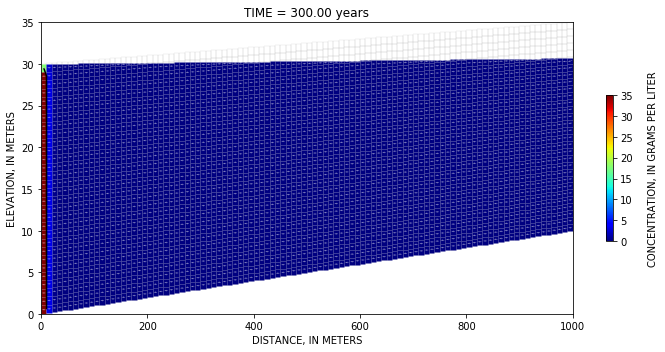

In [13]:
istp = -1
sl = get_sealevel(times[istp], sl_start, slr_rate)
make_figure(gwf, head0[istp], conc0[istp], spdis0[istp], 
            sl, times[istp], top0, slopels, vectors=True)

In [14]:
make_png = False
if make_png:

    pngdir = os.path.join(ws0, 'png')
    if os.path.isdir(pngdir):
        shutil.rmtree(pngdir)
    if not os.path.isdir(pngdir):
        os.mkdir(pngdir)

    kperlist = range(0, conc0.shape[0], 10)
    #kperlist = [0]
    for ifig, kper in enumerate(kperlist):
        fname = 'img{}.png'.format(ifig)
        fname = os.path.join(pngdir, fname)
        print('writing {}'.format(fname))

        sl = get_sealevel(times[kper], sl_start, slr_rate)
        make_figure(gwf, head0[kper], conc0[kper], spdis0[kper], 
                    sl, times[kper], top0, slopels, 
                    vectors=True, figname=fname)
        
    # Use ffmpeg to make an animation
    figfile = os.path.join(pngdir, 'img%d.png')
    anmfile = os.path.join(ws0, 'movie.mp4')
    make_movie(figfile, anmfile)

In [15]:
make_cinema = False
    if make_cinema:
    # Use ffmpeg to make an animation
    figfile = os.path.join(pngdir, 'img%d.png')
    anmfile = os.path.join(ws0, 'movie.mp4')
    make_movie(figfile, anmfile)

IndentationError: unexpected indent (<ipython-input-15-8cf5f9048e46>, line 2)

# Run with Sea Level Rise using results of the previous as starting

In [ ]:
ws = 'temp/pxx_gwt_slr'
name = 'slr'
# get starting heads and concs from the no SLR results above
hstrt = head0[-1]
cstrt = conc0[-1]

nper = 2000

# gradual sea level rise
# time_end should be 100 years
# not using constant concentration for this simulation
sl_start = 30.
slr_rate = 1 / 100. / 365.
time_end = 100 * 365

# instantaneous sea level rise 
# should also have constant concentration
# reaches steady state at 30 years, so adjust time_end to reflect this 
#sl_start = 31.
#slr_rate = 0.
#time_end = 30. * 365

sim = get_model(ws, name, nlay, nrow, ncol, lx, slopels, slopebot, 
                top0, sl_start, slr_rate, time_end, 
                hydraulic_conductivity, specific_storage, porosity, 
                recharge, inflow_rate,
                alpha_l, alpha_t,
                cfresh, csalt,
                hstrt=hstrt, cstrt=cstrt,
                constant_concentration=True,
                verbosity_level=1, nper=nper)
sim.write_simulation()
v = sim.run_simulation(report=True)
head, conc, spdis, times = get_results(ws, sim)

In [ ]:
istp = -1
sl = get_sealevel(times[istp], sl_start, slr_rate)
make_figure(gwf, head[istp], conc[istp], spdis[istp], 
            sl, times[istp], top0, slopels,
            vectors=True)

In [ ]:
make_png = True
if make_png:

    pngdir = os.path.join(ws, 'png')
    if os.path.isdir(pngdir):
        shutil.rmtree(pngdir)
    if not os.path.isdir(pngdir):
        os.mkdir(pngdir)

    kperlist = range(0, conc.shape[0], 10)
    #kperlist = [nper - 1]
    for ifig, kper in enumerate(kperlist):
        fname = 'img{}.png'.format(ifig)
        fname = os.path.join(pngdir, fname)
        print('writing {}'.format(fname))

        sl = get_sealevel(times[kper], sl_start, slr_rate)
        make_figure(gwf, head[kper], conc[kper], spdis[kper], 
                    sl, times[kper], top0, slopels, 
                    vectors=True, figname=fname)
        
    # Use ffmpeg to make an animation
    figfile = os.path.join(pngdir, 'img%d.png')
    anmfile = os.path.join(ws, 'movie.mp4')
    make_movie(figfile, anmfile)

In [ ]:
make_cinema = True
if make_cinema:
    # Use ffmpeg to make an animation
    figfile = os.path.join(pngdir, 'img%d.png')
    anmfile = os.path.join(ws, 'movie.mp4')
    make_movie(figfile, anmfile)

In [ ]:
make_vtk = True
if make_vtk:
    vtkdir = os.path.join(ws, 'vtk')
    if not os.path.isdir(vtkdir):
        os.mkdir(vtkdir)
    from flopy.export.vtk import Vtk
    for kper in range(0, conc.shape[0], 25):
        fname = 'slr-{}.vtu'.format(kper)
        fname = os.path.join(vtkdir, fname)
        print('writing {}'.format(fname))
        vtk = Vtk(fname, model=gwf)
        vtk.add_array('CONCENTRATION', np.float32(conc[kper]))
        vtk.write(ibound_filter=True, htop=np.float32(head[kper]))

In [ ]:
2000/10
